Note, still in the process of experimenting with parameters

Import packages

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
import datetime as dt

In [2]:
data = pds.read_pickle('../../downsampled_data.pkl')

One hot encode segments, normalize columns and create final dataset

In [5]:
df = data

In [7]:
# Make segments categorical
dataset = pds.get_dummies(df['seg'])

# Combine segments, timestamps and time from journey start

# Cyclical timestamps 
dataset['hr_sin'] = np.sin(df.timestamp.str[11:13].astype(int)*(2.*np.pi/24))
dataset['hr_cos'] = np.cos(df.timestamp.str[11:13].astype(int)*(2.*np.pi/24))

#dataset['speed'] = (df['speed']-df['speed'].min())/(df['speed'].max()-df['speed'].min())

dataset['progress'] = df['progress']

# Include journey number to select entire journeys
dataset['traj'] = df['traj']

dataset.head()

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,hr_sin,hr_cos,progress,traj
0,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,-1.455559,1.0
1,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,-1.383743,1.0
2,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,-1.345973,1.0
3,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,-1.235342,1.0
4,1,0,0,0,0,0,0,0,0,0,0,0.866025,0.5,-1.227545,1.0


Select an arbitrary number of test journeys

In [8]:
# Roughly 20%
num_test_segments = 700 
msk = np.random.randint(1, dataset.traj.unique()[-1], num_test_segments)
mask = dataset['traj'].isin(msk)

Divide training and test data, 80% training data

In [9]:
train_input = dataset[~mask]
test_input = dataset[mask]

train_labels = df['t'][~mask]
test_labels = df['t'][mask]

In [10]:
# Journey numbers were needed up until this point
train_data = train_input.drop(columns=['traj'])
test_data = test_input.drop(columns=['traj'])

Build model

In [11]:
model = keras.Sequential([
	keras.layers.Dense(len(train_data.columns), activation=tf.nn.sigmoid, input_shape=(train_data.shape[1],)),
    keras.layers.Dense(len(train_data.columns)),
    keras.layers.Dense(3),
	keras.layers.Dense(1)
	])

#optimizer = tf.train.RMSPropOptimizer(0.001)
optimizer = keras.optimizers.Adadelta()
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 14)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 45        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4         
Total params: 469
Trainable params: 469
Non-trainable params: 0
_________________________________________________________________
None


Fit model, 10% of the training data is used as validation set

In [12]:
EPOCHS=5
# Initial_epoch can be set to resume training after preciously run epochs
model.fit(train_data.values, train_labels.values, epochs = EPOCHS, validation_split=0.1, initial_epoch=0)

Train on 1998654 samples, validate on 222073 samples
Epoch 1/5
1998654/1998654 [==============================] - 43s 21us/step - loss: 8.9815 - mean_absolute_error: 8.9815 - val_loss: 8.8365 - val_mean_absolute_error: 8.8365
Epoch 2/5
1998654/1998654 [==============================] - 41s 21us/step - loss: 8.4635 - mean_absolute_error: 8.4635 - val_loss: 8.8077 - val_mean_absolute_error: 8.8077
Epoch 3/5
1998654/1998654 [==============================] - 42s 21us/step - loss: 8.3714 - mean_absolute_error: 8.3714 - val_loss: 8.6731 - val_mean_absolute_error: 8.6731
Epoch 4/5
1998654/1998654 [==============================] - 42s 21us/step - loss: 8.3112 - mean_absolute_error: 8.3112 - val_loss: 8.6214 - val_mean_absolute_error: 8.6214
Epoch 5/5
1998654/1998654 [==============================] - 41s 21us/step - loss: 8.2601 - mean_absolute_error: 8.2601 - val_loss: 8.7211 - val_mean_absolute_error: 8.7211


Save model to disk

In [13]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model2v3.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

# Serialize weights to HDF5
model.save_weights("model2v3.h5")

Load model example

In [8]:
# Load YAML and create model
yaml_file = open('model2v3.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
model = keras.models.model_from_yaml(loaded_model_yaml)

# Load weights into new model
model.load_weights("model2v3.h5")

In [9]:
#optimizer = tf.train.RMSPropOptimizer(0.001)
optimizer = keras.optimizers.Adadelta()
model.compile(loss='mae', optimizer = optimizer, metrics=['mae'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_31 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_32 (Dense)             (None, 3)                 60        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 4         
Total params: 824
Trainable params: 824
Non-trainable params: 0
_________________________________________________________________
None


## Evaluate model on all segments 

Evaluate model

In [14]:
model.evaluate(test_data.values, test_labels.values)

472784/472784 [==============================] - 3s 7us/step


[8.26397513442001, 8.26397513442001]

An arbitrary number from `msk` is chosen, i.e. a journey, to a comparison with original data.

In [16]:
selected_journey = np.random.choice(msk)
to_test = test_input[test_input['traj'] == selected_journey]
model_to_predict = to_test.drop(columns=['traj'])
predictions = model.predict(model_to_predict.values, batch_size=1, verbose=1)

810/810 [==============================] - 0s 175us/step


In [17]:
journey_ = test_input.index[test_input['traj'] == selected_journey]
j_labels = test_labels.loc[journey_]
j_labels = j_labels.reset_index().drop(columns=['index'])

Green line is the predicted time, red is the actual time. Note that the predicted time is the time it takes to drive an entire segment.


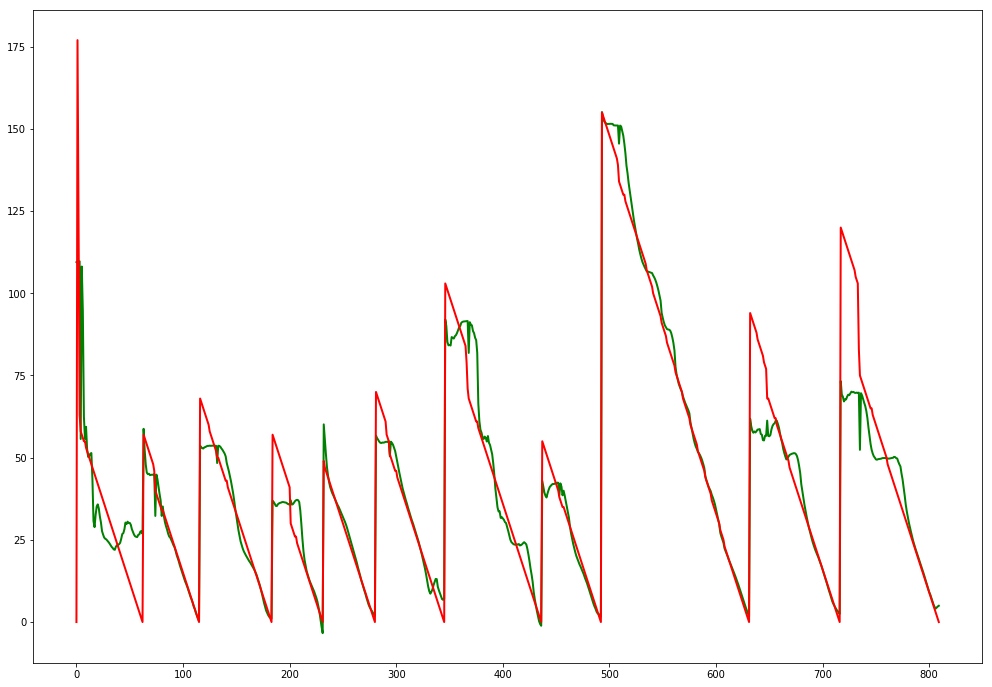

In [18]:
plt.rcParams['figure.figsize'] = [17, 12]
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(j_labels, color='red', linewidth=2, markersize=12)
plt.show()

Note that the plot above contains all 11 segments. The first segment has trouble finding a good estimate in the beginning, probably because the bus stays idle on this station (ändhållplatsen) for a long time

## Evaluate model on all but the first segment

Create a set that ignores the first segment

In [19]:
# Drop first segment, all journeys
test_ign = test_data[test_data[1] == 0].index
test_ign_d = test_data.loc[test_ign]
test_ign_l = test_labels.loc[test_ign]

# Drop first segment, single journey

# Selected journey needs to be in the msk array
# selected_journey = np.random.choice(msk)

# Selected_journey from previous example should be used to compare loss

test_single_j = test_input[test_input['traj'] == selected_journey]
to_test = test_single_j.drop(columns=['traj'])

test_single = to_test[to_test[1] == 0].index
test_single_d = to_test.loc[test_single]
journey_ = test_labels[test_input['traj'] == selected_journey]
test_single_l = journey_.loc[test_single]
test_single_l = test_single_l.reset_index().drop(columns=['index'])

Evaluate model on all data

In [20]:
model.evaluate(test_ign_d.values, test_ign_l.values)

425638/425638 [==============================] - 3s 8us/step


[7.0985511181031535, 7.0985511181031535]

About 7 seconds m.a.e. Really good to drop the first segment!

In [21]:
predictions = model.predict(test_single_d.values, batch_size=1, verbose=1)

747/747 [==============================] - 0s 150us/step


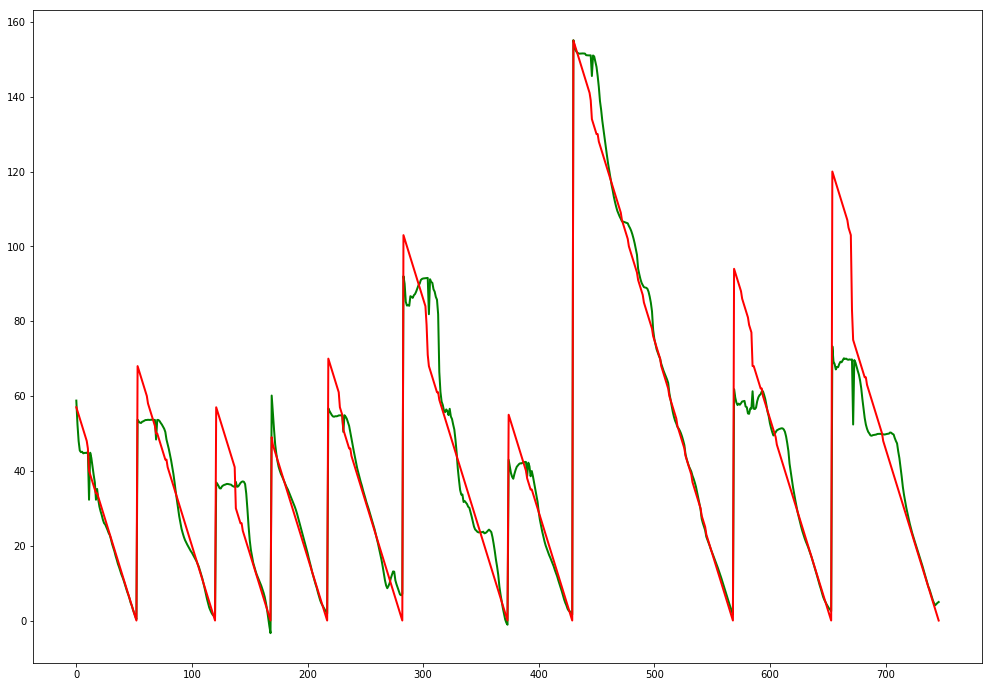

747/747 [==============================] - 0s 8us/step
[5.434148238365909, 5.434148238365909]


In [23]:
plt.rcParams['figure.figsize'] = [17, 12]
plt.plot(predictions, color='green', linewidth=2, markersize=12)
plt.plot(test_single_l, color='red', linewidth=2, markersize=12)
plt.show()
print(model.evaluate(test_single_d.values, test_single_l.values))

It is easy to see that it has troubles dealing with dwell time at bus stops.

Below is a final scatterplot from the entire test data set. But this is very hard to interpret.

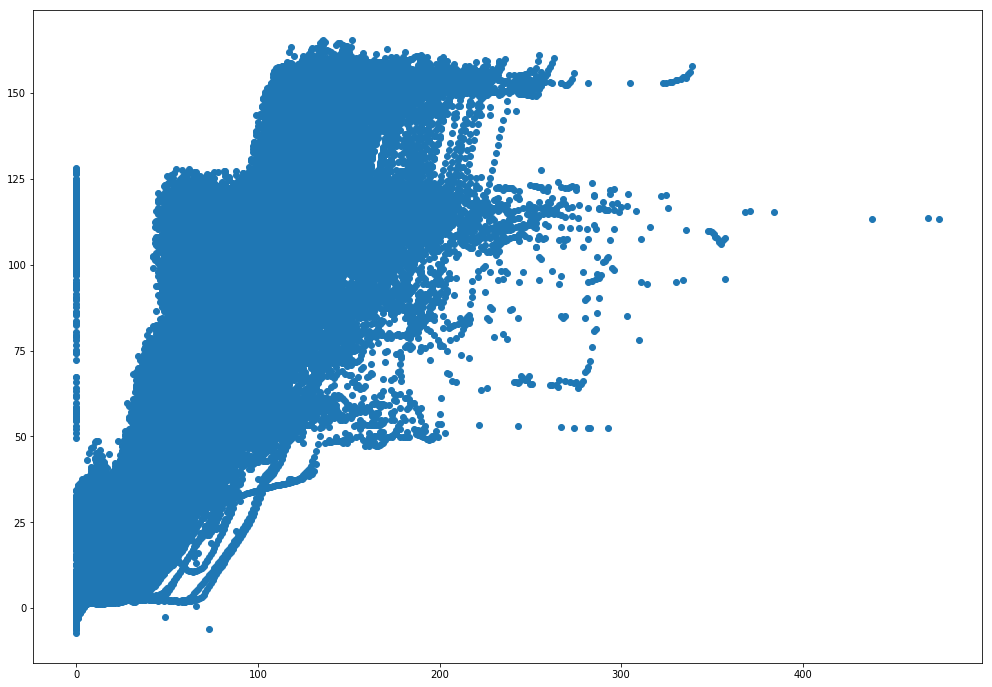

In [24]:
test_predictions = model.predict(test_data.values)
plt.scatter(test_labels.values, test_predictions)
plt.show()

## Now, lets look only at segment 9 (McD to Gamla Linköping)

In [25]:
# Drop first segment, all journeys
test_ign = test_input[test_input[9] == 1].index
test_ign_d = test_input.loc[test_ign]
test_ign_l = test_labels.loc[test_ign]
#test_ign_l = test_ign_l.reset_index().drop(columns=['index'])

In [27]:
eval_data = [] #pds.DataFrame()
eval_labels = [] #pds.DataFrame()

for i, seg in test_ign_d.groupby('traj'):
    n_seg = seg.drop(columns=['traj'])
    n_idx = n_seg.index
    pred = model.predict(n_seg, verbose=0)
    eval_data.append([pred])
    eval_labels.append([test_ign_l.loc[n_idx].reset_index().drop(columns=['index'])])
    #eval_data = pds.concat(eval_data, pred)
    #eval_labels = pds.concat(eval_labels, test_ign_l.loc[n_idx].reset_index().drop(columns=['index']), axis=2)

Looking att all predictions at the same time shows interesting results! Some journeys (the rightmost) seems to have large troubles with 

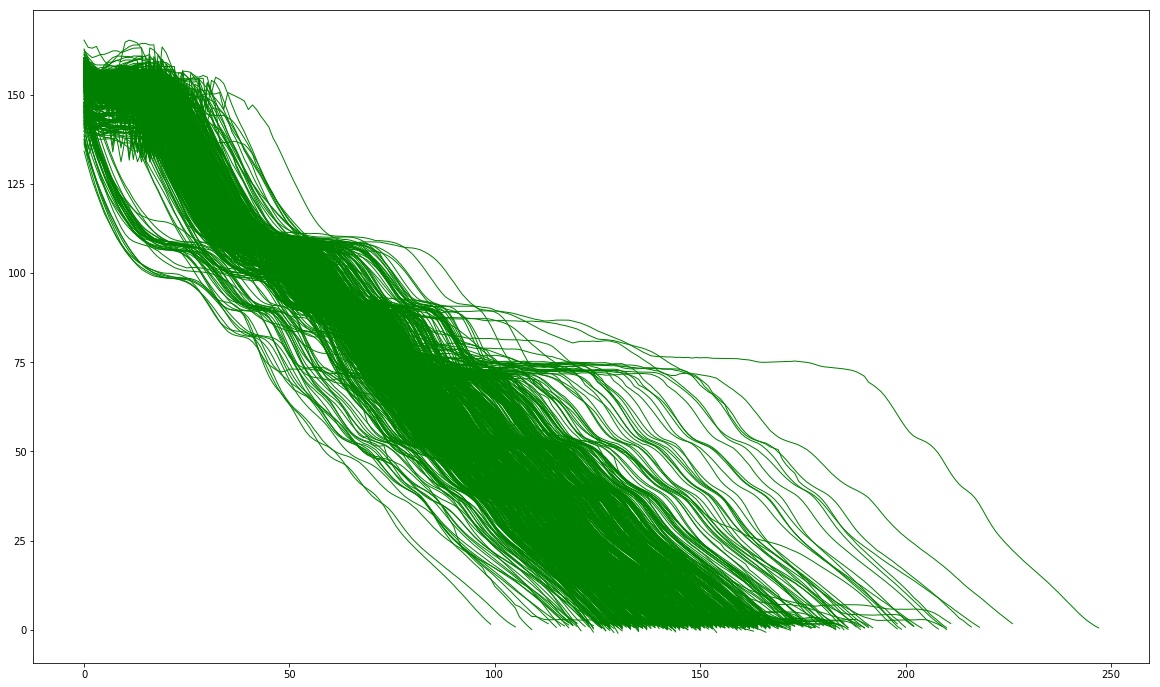

In [28]:
plt.rcParams['figure.figsize'] = [20, 12]
for i in range(len(eval_data)):
    plt.plot(eval_data[i][0], color='green', linewidth=1, markersize=2)
    #plt.plot(eval_labels[i][0], color='red', linewidth=2, markersize=12)
plt.show()
#print(model.evaluate(test_ign_d.values, test_ign_l.values))

There seems to be large variance in this route. This is the segment containing Vallarondellen, which is known for having large traffic issues from time to time. This is probably why some journeys are very far to the right and the 